<a href="https://colab.research.google.com/github/M2Lschool/tutorials2023-dev/blob/main/2_generative/notebooks/2_1_vaes/2_1_vaes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoders (VAE)
---
**Authors:** **[Nemanja Rakicevic](https://nemanja-rakicevic.github.io/)** and **[Manos Kirtas](https://scholar.google.com/citations?user=EyaKPkwAAAAJ&hl=en)**


**Tutorial overview:**
In this tutorial you will implement, train and analyse the results of a Variational AutoEncoder.


**Tutorial outline:**
- [Setup](#setup)
  - Install and Import Packages
  - Dataset
  - Helper Functions
- [Implementing VAE components](#implement-vae)
  - Encoder
  - Decoder
  - Loss functions
- [Training and Visualisation](#training)
  - Train Utils
  - Main Train Loop
  - Run Training
- [Analysis](#analysis)


## Setup <a class="anchor" id="setup"></a>  

### Install and Import Packages

In [ ]:
#@title Install Packages
! pip install numpy==1.25.2
! pip install chex -q
! pip install optax -q
! pip install distrax -q
! pip install dm_haiku -q
! pip install absl-py -q

In [ ]:
#@title Import Packages
import dataclasses
from typing import Mapping, NamedTuple, Sequence, Tuple, Iterator

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]

SAMPLE_SHAPE: Sequence[int] = (28, 28, 1)

### Dataset

In this tutorial we will use a small subset of CelebA dataset. We will load the standaert CelebA dataset from which we select a few celebrities,  and a small number of samples for each celebrity. This will allow us to train the models faster and visualize them easily.

More specifically, we denote dataset as $\mathcal{D}$ consisting of $N\geq1$ datapoints:
$$
  \mathcal{X} = \{x^{(1)}, x^{(2)}, \ldots, x^{(N)}\} ≡ \{x^{(i)}\}
_{i=1}^{N}.$$
The datapoints are assumed to be intependednt sample from an unchanging underlying distribution. Formally, the observations $\mathcal{X}=\{x^{(i)}\}
_{1}^{N}$ are said to be independently and identically distributed. Under this assumption, the log probability assigned to the data by the model is therefore given by:
$$
\log p_{\theta}(\mathcal{D}) = \sum_{\mathbb{x}\in\mathcal{X}}\log p_{\mathbb{\theta}}(\mathbb{x}),
$$where $\theta$ is the trainable parameters of the model.

In [ ]:
# @title Dataset loading and visualisation helper functions
# @markdown We can use TensorFlow data (`tfds`) to download MNIST from the cloud.
# @markdown <br>[Chex](https://github.com/deepmind/chex) is a library of utilities helping to write more reliable JAX code.
# @markdown Within `chex` you will find a `dataclass` object definition, which will automatically register new class instances into JAX, so you can easily apply JAX's tree utilities out of the box. We will use it to define a labelled data object type.


def load_dataset(split: str, batch_size: int,
                 random_seed: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()

    return iter(tfds.as_numpy(ds))


## Variational Autoencoders <a class="anchor" id="implement-vae"></a>  


Consider a joint distribution $p(x, z)$ over a set of latent variables $z \in \mathcal{Z}$ and observed variable $x \in \mathcal{X}$ (for instance, the images of our dataset).

Inference over the observed variable $x$ involves computing the posterior distribution $p(z|x) = \frac{p(x,z)}{p(x)}$ is often intractable to compute, as the _marginal likelihood_ $p(x) = \int_z p(x, z)dz$ requires integrating over a potentially exponential number of configurations of $z$.

In order to turn the deep latend-variable model's intractable posterior inference and learning problem into tractable problem, we introduce an inference model $q_\phi(\mathbf{z}|\mathbf{x})$, which is called **encoder**., with $\phi$ indicates the trainable parameters of the inference model.

### Encoder - Posterior function modelling

**Variational Inference (VI)** can be used to approximate the posterior $p(z|x)$ in a tractable fashion. VI casts the problem of computing the posterior as an optimization problem introducing a family of tractable (simpler) distribution $\mathcal{Q}$ parametrized by $\phi$. The objective is to find the best approximation of the true posterior $q_{\phi^*} \in \mathcal{Q}$ that minimizes the Kullback-Leibler (KL) divergence with the exact prosterior:

$$
q_{\phi^*}(z) = \underset{q_{\phi}}{arg min} \ \ D_{KL}(q_{\phi}(z) || p(z|x))
$$

$q_{\phi^*}(z)$ can serve as a proxy for the true posterior distribution. Note that the solution depends on the speciﬁc value of the observed (evidence) variables $x_i$ we are conditioning on, so computing the posterior requires solving an optimization problem for each sample independently.

In this tutorial, we use a much more efficient approach. Rather than solving an optimization process per data point, we can **amortize the cost of inference** by leveraging the power of function approximation and learn a deterministic mapping to predict the distributional variables as a function of $x$. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters shared across all data points.


<img src="https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png" alt="VAE" width="800"/>

[Image credit: [lilianweng.github.io](https://lilianweng.github.io/posts/2018-08-12-vae/)]


The simplest posterior model is a diagonal Gaussian
$q_{\phi}(z|x) = \mathcal{N}(z|\mu_{\phi}(x), diag(\sigma^2_{\phi}(x)))$, where $q_{\theta}$ can be modelled e.g. using a neural network, whose outputs define the parameters  $z = \{\mu_{\phi}, \sigma^2_{\phi} \}$ of the distribution.

However, the Gaussian distribution is not allow as to return gradients. To this end, sampling from this Gaussian is achieved employing the **reparameterization trick** that disentangles the noise source, so that the gradients can be backpropagated:
$$
z \sim \mathcal{N}(z|\mu, \sigma^2) \Leftrightarrow z = \mu + \sigma\epsilon,  \epsilon \sim \mathcal{N}(0, 1)
$$




<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" alt="VAE reparameterisation trick" width="800"/>

[Image credit: [lilianweng.github.io](https://lilianweng.github.io/posts/2018-08-12-vae/)]
`


In [ ]:
#@title Encoder Implementation
class Encoder(hk.Module):
    """Encoder model."""
    def __init__(
        self,
        hidden_size1: int = 50,
        hidden_size2: int = 25,
        latent_size: int = 10,
    ):
        super().__init__()
        self._hidden_size1 = hidden_size1
        self._hidden_size2 = hidden_size2
        self._latent_size = latent_size
        self.act = jax.nn.relu

    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:

        x = hk.Flatten()(x)


        # hint: hk.Linear -> https://dm-haiku.readthedocs.io/en/latest/api.html?highlight=linear#linear
        x = hk.Sequential([
            ######################## CODE AFTER ########################

            ######################## CODE BEFORE ########################
        ])(x)

        ######################## CODE AFTER ########################
        mean =
        ######################## CODE BEFORE ########################


        ######################## CODE AFTER ########################
        log_stddev =
        ######################## CODE BEFORE ########################

        stddev = jnp.exp(log_stddev)

        # hint: jax.random.normal -> https://jax.readthedocs.io/en/latest/_autosummary/jax.random.normal.html
        ######################## CODE AFTER ########################
        z =
        ######################## CODE BEFOR ########################

        return z, mean, stddev

### Decoder

In [ ]:
class Decoder(hk.Module):
    """Decoder model."""
    def __init__(
        self,
        hidden_size: int = 512,
        output_shape: Sequence[int] = SAMPLE_SHAPE,
    ):
        super().__init__()
        self._hidden_size = hidden_size
        self._output_shape = output_shape

    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:

        ######################## CODE AFTER ########################
        z =
        z =
        ######################## CODE BEFORE ########################

        logits = hk.Linear(np.prod(self._output_shape))(z)
        logits = jnp.reshape(logits, (-1, *self._output_shape))

        return logits


In [ ]:
#@title Variational Autoencoder Implementation
class VAEOutput(NamedTuple):
    image: jnp.ndarray
    mean: jnp.ndarray
    stddev: jnp.ndarray
    logits: jnp.ndarray


@dataclasses.dataclass
class VariationalAutoEncoder(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    encoder: Encoder
    decoder: Decoder

    def __call__(self, x: jnp.ndarray) -> VAEOutput:
        x = x.astype(jnp.float32)

        ######################## CODE AFTER ########################
        z, mean, stddev =

        logits =
        ######################## CODE BEFORE ########################

        p = jax.nn.sigmoid(logits)
        image = jax.random.bernoulli(hk.next_rng_key(), p)

        return VAEOutput(image, mean, stddev, logits)

@hk.transform
def model(x):
    ######################## CODE AFTER ########################
    vae =
    ######################## CODE BEFORE ########################
    return vae(x)


### Loss Functions


We use maximum likelihood for training, that is, ideally we would like to maximize:

$$\mathbb{E}_{x \sim P^*}\log p_{\theta}(x)$$

Note that $p_{\theta}(x)$ is the marginal probability distribution $p_{\theta}(x) = \int p_\theta(x, z) dz$. We can rewrite this in familiar terms as $\int p_\theta(x|z) p(z) dz$. However, computing (and maximizing) the above marginal is computationally infeasible.

Instead, we can show:

$$\log p_{\theta}(x) \ge \mathbb{E}_{z \sim q(z|x)} \big[\log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big)$$

This right hand side is called the evidence lower bound (ELBO). Broadly speaking the term variational methods, like variational inference, refers to this technique of using an approximate posterior distribution and the ELBO; this is where Variational Autoencoder gets its name from too.

In order to try to maximize the likelihood, we maximize the lower bound (ELBO) instead, using e.g. Stochastic Gradient Descent. This yields the following loss used with Variational AutoEncoders:

<font size=4>
<!-- $$ \\mathcal{L}(X, z) = \\mathbb{E}\\big[\\log P(X|z)\\big] - D_{KL}\\big[Q(z|X) \\big|\\big| P(z)\\big].$$ -->
$$
\mathcal{L}(x) = - \Big( \mathbb{E}_{z \sim q(z|x)} \big [ \log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big) \Big)
$$
</font>

<br>

Therefore, training this model is called Stochastic Variational Inference.

Observe that:
* The first term encourages the model to reconstruct the input faithfully. This part is similar to the Vanilla AutoEncoder.
* The second term can be seen as a *regularization term* of the encoder towards the prior.

(The formula contains an expectation; in practice that would be approximated with one or more samples.)

In [ ]:
def kl_gaussian(mean: jnp.ndarray, var: jnp.ndarray) -> jnp.ndarray:
    r"""Calculate KL divergence between given and standard gaussian distributions.

    KL(p, q) = H(p, q) - H(p) = -\int p(x)log(q(x))dx - -\int p(x)log(p(x))dx
            = 0.5 * [log(|s2|/|s1|) - 1 + tr(s1/s2) + (m1-m2)^2/s2]
            = 0.5 * [-log(|s1|) - 1 + tr(s1) + m1^2] (if m2 = 0, s2 = 1)

    Args:
        mean: mean vector of the first distribution
        var: diagonal vector of covariance matrix of the first distribution

    Returns:
        A scalar representing KL divergence of the two Gaussian distributions.
    """
    kl_coeff = 0.5

    #hint: jnp.logaddexp -> https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.logaddexp.html
    ######################## CODE AFTER ########################
    return
    ######################## CODE BEFORE ########################

In [ ]:
def binary_cross_entropy(x: jnp.ndarray, logits: jnp.ndarray) -> jnp.ndarray:
    """Calculate binary (logistic) cross-entropy from distribution logits.

    Args:
        x: input variable tensor, must be of same shape as logits
        logits: log odds of a Bernoulli distribution, i.e. log(p/(1-p))

    Returns:
        A scalar representing binary CE for the given Bernoulli distribution.
    """
    if x.shape != logits.shape:
        raise ValueError("inputs x and logits must be of the same shape")

    x = jnp.reshape(x, (x.shape[0], -1))
    logits = jnp.reshape(logits, (logits.shape[0], -1))

    ######################## CODE AFTER ########################
    return
    ######################## CODE BEFORE ########################

In [ ]:
@jax.jit
def loss_fn(
    params: hk.Params,
    rng_key: PRNGKey,
    batch: Batch,
) -> jnp.ndarray:
    """ELBO: E_p[log(x)] - KL(d||q), where p ~ Be(0.5) and q ~ N(0,1)."""
    outputs: VAEOutput = model.apply(params, rng_key, batch["image"])

    ######################## CODE AFTER ########################
    log_likelihood =
    kl =

    elbo =
    ######################## CODE BEFORE ########################

    return -jnp.mean(elbo)


## Training and Visualisation  <a class="anchor" id="training"></a>

In [ ]:
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng_key: jax.Array


def get_config():
  batch_size = 16 #@param
  learning_rate = 0.001 #@param
  training_steps = 2000 #@param
  eval_frequency = 200 #@param
  random_seed = 42 #@param
  kappa_constrained = 0.1 #@param

config = get_config()

#hint: https://optax.readthedocs.io/en/latest/api.html
######################## CODE AFTER ########################
optimizer =
######################## CODE BEFORE ########################

@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Performs a single SGD step."""
    rng_key, next_rng_key = jax.random.split(state.rng_key)

    gradients = jax.grad(loss_fn)(state.params, rng_key, batch)

    updates, new_opt_state = optimizer.update(gradients, state.opt_state)

    new_params = optax.apply_updates(state.params, updates)

    return TrainingState(new_params, new_opt_state, next_rng_key)


def train_simple_vae(config):
    # Load datasets
    train_ds = load_dataset(tfds.Split.TRAIN, config['batch_size'],
                            config['random_seed'])
    valid_ds = load_dataset(tfds.Split.TEST, config['batch_size'],
                            config['random_seed'])

    # Initialization
    initial_rng_key = jax.random.PRNGKey(config['random_seed'])
    initial_params = model.init(initial_rng_key, next(train_ds)['image'])
    initial_opt_state = optimizer.init(initial_params)
    state = TrainingState(initial_params, initial_opt_state, initial_rng_key)

    img_dict = {'step': [], 'image': [], 'elbo': []}
    loss_acc = []
    for step in range(config['training_steps']):

        state = update(
            state,
            next(train_ds),
        )

        if step % config['eval_frequency'] == 0:
            batch = next(valid_ds)
            val_loss = loss_fn(state.params, state.rng_key, batch)

            print("Step: {}; Validation ELBO: {}".format(step, val_loss))

            outputs = model.apply(state.params, state.rng_key, batch["image"])

            rnd_idx = jax.random.randint(state.rng_key, (1, ), 0,
                                         len(outputs))[0]

            img_dict['step'].append(step)
            img_dict['image'].append(outputs.image.astype(int)[rnd_idx])
            img_dict['elbo'].append(val_loss.item())

    return img_dict


In [ ]:
img_dict = train_simple_vae(config)

Step: 0; Validation ELBO: 517.9081420898438
Step: 200; Validation ELBO: 174.29354858398438
Step: 400; Validation ELBO: 168.9801025390625
Step: 600; Validation ELBO: 147.33201599121094
Step: 800; Validation ELBO: 147.86509704589844
Step: 1000; Validation ELBO: 136.64549255371094
Step: 1200; Validation ELBO: 137.9427032470703
Step: 1400; Validation ELBO: 134.4289093017578
Step: 1600; Validation ELBO: 143.27317810058594
Step: 1800; Validation ELBO: 129.44644165039062


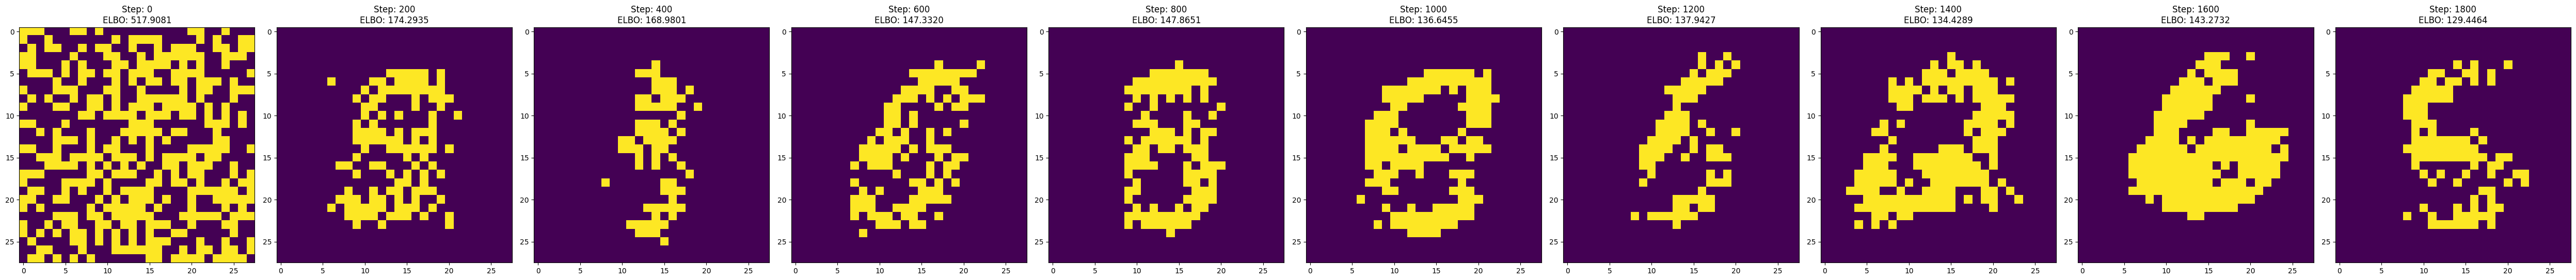

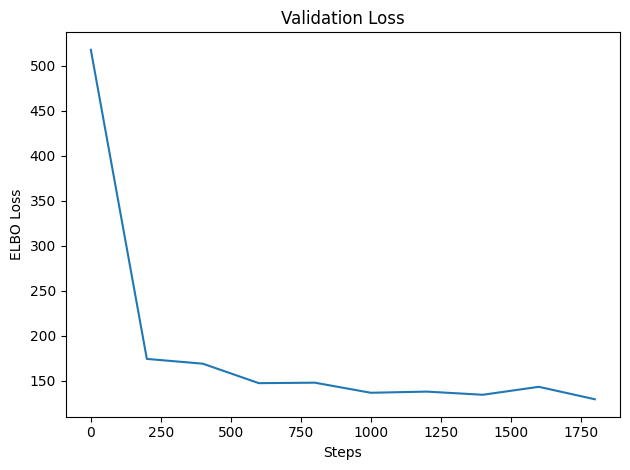

In [ ]:
def plot_training_progress(img_dict):
    fig, axes = plt.subplots(1, len(img_dict['step']), figsize=(50, 150))

    for i in range(len(img_dict['step'])):

        axes[i].set_title('Step: {}\nELBO: {:.4f}'.format(
            img_dict['step'][i], img_dict['elbo'][i]))
        axes[i].imshow(img_dict['image'][i])

    plt.tight_layout()
    plt.show()

def plot_loss(img_dict):
  fig, ax = plt.subplots(1, 1)

  ax.plot(img_dict['step'], np.array(img_dict['elbo']))

  ax.set_title("Validation Loss")
  ax.set_ylabel('ELBO Loss')
  ax.set_xlabel('Steps')

  plt.tight_layout()
  plt.show()

plot_training_progress(img_dict)
plot_loss(img_dict)

## Analysis  <a class="anchor" id="analysis"></a>

What's the effect of changing the batch size regarding the performance and training efficiency? Can you comment on that?

How the latent space size effects the performance of VAEs?

Introduce coefficients to weight the KL divergence and cross entropy loss? How the training process is affected?  

Use diffrent optimizers.